In [1]:
import datetime
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns
from time import perf_counter
import xgboost as xgb
from joblib import Parallel, delayed
from numpy import linalg as LA
import pandas as pd
from scipy.signal import butter, lfilter, freqz
import src.utils.preprocess as pre
from tst import Transformer
# from tst import Transformer_with_sst
import os
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.neural_network import MLPRegressor

In [2]:
path = '/share/data/willett-group/'

us_mask = pd.DataFrame(pd.read_hdf(path + 'us_mask.h5'))
# This block is to put all nearby sst data together in time order
# And also transform data into time order (single location\)
# previous lat/lon = 25.25, 279.25
tar_lat = 33.75
tar_lon = 242.25
radius = 5  # For selecting range of locations from target
y_samp = pd.Series()
sst_total = []
precip_total = []
hgt_total = []
rhum_total = []
tmp2m_total = []

# !!! 1985-2019

for i in range(2014,2019):
    print('precip.'+str(i)+'.h5')
    name_precip = 'precip.'+str(i)+'.h5'
    name_sst = 'sst.'+str(i)+'.h5' 
    name_hgt = 'hgt500.'+str(i)+'.h5'
    name_rhum = 'rhum.sig995.'+str(i)+'.h5'
    name_tmp2m = 'tmp2m.'+str(i)+'.h5'
    fileloc_precip = path + name_precip
    fileloc_sst = path + name_sst
    fileloc_hgt = path + name_hgt
    fileloc_rhum = path + name_rhum
    fileloc_tmp2m = path + name_tmp2m
    precip = pd.DataFrame(pd.read_hdf(fileloc_precip)).reset_index() # precipitation
    precip.columns = ['lat', 'lon', 'start_date', 'precip']
    sst = pd.DataFrame(pd.read_hdf(fileloc_sst)).reset_index() # Daily sea surface temperature
    sst.columns = ['lat', 'lon', 'start_date', 'sst']
    hgt = pd.DataFrame(pd.read_hdf(fileloc_hgt)).reset_index() # Daily geopotential height at 10mb and 500mb
    hgt.columns = ['lat', 'lon', 'start_date', 'hgt']
    rhum = pd.DataFrame(pd.read_hdf(fileloc_rhum)).reset_index() # Daily relative humidity near the surface
    rhum.columns = ['lat', 'lon', 'start_date', 'rhum']
    tmp2m = pd.DataFrame(pd.read_hdf(fileloc_tmp2m)).reset_index() # Daily average temperature at 2 meters
    tmp2m.columns = ['lat', 'lon', 'start_date', 'tmp2m']
#     print('original', tmp2m.shape)
    
    precip = pd.merge(precip, us_mask, on=['lat','lon'])
    hgt = pd.merge(hgt, us_mask, on=['lat','lon'])
    rhum = pd.merge(rhum, us_mask, on=['lat','lon'])
    tmp2m = pd.merge(tmp2m, us_mask, on=['lat','lon'])
#     print('after merge', tmp2m.shape)
    
#     hgt = np.reshape(hgt[(hgt['lat']==tar_lat) & (hgt['lon']==tar_lon)].hgt.to_numpy(),(-1,1))
#     rhum = np.reshape(rhum[(rhum['lat']==tar_lat) & (rhum['lon']==tar_lon)].rhum.to_numpy(),(-1,1))
#     tmp2m = np.reshape(tmp2m[(tmp2m['lat']==tar_lat) & (tmp2m['lon']==tar_lon)].tmp2m.to_numpy(),(-1,1))
#     precip = precip[(precip['lat']==tar_lat) & (precip['lon']==tar_lon)].precip
#     print('one location', tmp2m.shape)
    
    y_samp = y_samp.append(precip[0:365],ignore_index=True)
    
    if i%4 == 0:
        days = 366
    else:
        days = 365
    sst_temp = sst[(sst['lat']>=tar_lat-radius) & (sst['lat']<=tar_lat+radius) 
                   & (sst['lon']>=tar_lon-radius) & (sst['lon']<=tar_lon+radius)]
    sst_temp = sst_temp.sst.reset_index().sst.to_numpy()
    size = int(len(sst_temp)/days)
    sst_temp = np.reshape(sst_temp,(size, days)).transpose() # days as rows, different locations as columns
    sst_temp = sst_temp[0:365,:]
    sst_total.append(sst_temp)
    
    precip_temp = precip[(precip['lat']>=tar_lat-radius) & (precip['lat']<=tar_lat+radius) 
                   & (precip['lon']>=tar_lon-radius) & (precip['lon']<=tar_lon+radius)]
    precip_temp = precip_temp.precip.reset_index().precip.to_numpy()
    size = int(len(precip_temp)/days)
    precip_temp = np.reshape(precip_temp,(size, days)).transpose() # days as rows, different locations as columns
    precip_temp = precip_temp[0:365,:]
    precip_total.append(precip_temp)
    
    hgt_temp = hgt[(hgt['lat']>=tar_lat-radius) & (hgt['lat']<=tar_lat+radius) 
                   & (hgt['lon']>=tar_lon-radius) & (hgt['lon']<=tar_lon+radius)]
    hgt_temp = hgt_temp.hgt.reset_index().hgt.to_numpy()
    size = int(len(hgt_temp)/days)
    hgt_temp = np.reshape(hgt_temp,(size, days)).transpose() # days as rows, different locations as columns
    hgt_temp = hgt_temp[0:365,:]
    hgt_total.append(hgt_temp)
    
    rhum_temp = rhum[(rhum['lat']>=tar_lat-radius) & (rhum['lat']<=tar_lat+radius) 
                   & (rhum['lon']>=tar_lon-radius) & (rhum['lon']<=tar_lon+radius)]
    rhum_temp = rhum_temp.rhum.reset_index().rhum.to_numpy()
    size = int(len(rhum_temp)/days)
    rhum_temp = np.reshape(rhum_temp,(size, days)).transpose() # days as rows, different locations as columns
    rhum_temp = rhum_temp[0:365,:]
    rhum_total.append(rhum_temp)
    
    tmp2m_temp = tmp2m[(tmp2m['lat']>=tar_lat-radius) & (tmp2m['lat']<=tar_lat+radius) 
                   & (tmp2m['lon']>=tar_lon-radius) & (tmp2m['lon']<=tar_lon+radius)]
    tmp2m_temp = tmp2m_temp.tmp2m.reset_index().tmp2m.to_numpy()
    size = int(len(tmp2m_temp)/days)
    tmp2m_temp = np.reshape(tmp2m_temp,(size, days)).transpose() # days as rows, different locations as columns
    tmp2m_temp = tmp2m_temp[0:365,:]
    tmp2m_total.append(tmp2m_temp)
#     hgt = hgt[0:365,:]
#     rhum = rhum[0:365,:]
#     tmp2m = tmp2m[0:365,:]
    
    
#     all_features = np.concatenate((sst_samp,hgt,rhum,tmp2m),axis=1)
# #     print('all_features', all_features.shape)
#     X_total.append(all_features)
    
# X_size = X_total[0].shape[1]
# X_samp = np.zeros((1,X_size)) #  For concatenating all data
# # print(X_samp.shape)
# for i in range(len(X_total)):
#     X_samp = np.concatenate((X_samp,X_total[i]),axis = 0)
# X_samp = X_samp[1:]
# # print(X_samp.shape)

<ipython-input-2-d9169369565e>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_samp = pd.Series()


precip.2014.h5
precip.2015.h5
precip.2016.h5
precip.2017.h5
precip.2018.h5


In [3]:
sst_size = sst_total[0].shape[1]
sst_samp = np.zeros((1,sst_size))
for i in range(len(sst_total)):
     sst_samp = np.concatenate((sst_samp,sst_total[i]),axis = 0)
sst_samp = sst_samp[1:]

precip_size = precip_total[0].shape[1]
precip_samp = np.zeros((1,precip_size))
for i in range(len(precip_total)):
     precip_samp = np.concatenate((precip_samp,precip_total[i]),axis = 0)
precip_samp = precip_samp[1:]

hgt_size = hgt_total[0].shape[1]
hgt_samp = np.zeros((1,hgt_size))
for i in range(len(hgt_total)):
     hgt_samp = np.concatenate((hgt_samp,hgt_total[i]),axis = 0)
hgt_samp = hgt_samp[1:]

rhum_size = rhum_total[0].shape[1]
rhum_samp = np.zeros((1,rhum_size))
for i in range(len(rhum_total)):
     rhum_samp = np.concatenate((rhum_samp,rhum_total[i]),axis = 0)
rhum_samp = rhum_samp[1:]

tmp2m_size = tmp2m_total[0].shape[1]
tmp2m_samp = np.zeros((1,tmp2m_size))
for i in range(len(tmp2m_total)):
     tmp2m_samp = np.concatenate((tmp2m_samp,tmp2m_total[i]),axis = 0)
tmp2m_samp = tmp2m_samp[1:]

In [4]:
y_samp = y_samp.precip.to_numpy()

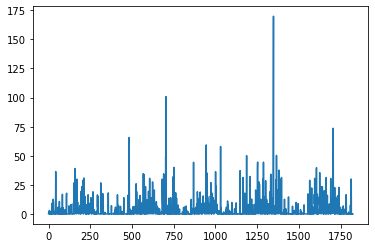

In [5]:
plt.plot(y_samp)

In [6]:
y_total = y_samp.copy()
X_total = np.concatenate((sst_samp,precip_samp,hgt_samp,rhum_samp,tmp2m_samp),axis=1)

# Calculate moving average for precip
avg_window = 14
y_movavg = []
X_movavg = []
for i in range(y_total.shape[0]-avg_window):
    y_avg = np.mean(y_total[i:i+avg_window])
    y_movavg.append(y_avg)
    X_avg = np.mean(X_total[i:i+avg_window],axis=0)
    X_movavg.append(X_avg)
y_movavg = np.array(y_movavg)
X_movavg = np.array(X_movavg)
y_total = y_movavg
X_total = X_movavg

train_size = int(y_total.shape[0]*0.8)
test_size = y_total.shape[0] - train_size
y_train = y_total[0:train_size]
y_test = y_total[train_size:]
X_train = X_total[0:train_size]
X_test = X_total[train_size:]

In [7]:
X_mins = np.amin(X_train,axis=0)
# y_min = np.amin(y_train,axis=0)
X_train = X_train - X_mins
X_test = X_test - X_mins
# y_train = y_train - y_min
# y_test = y_test - y_min
X_maxs = np.amax(X_train,axis=0)
# y_max = np.amax(y_train,axis=0)
X_train = X_train/X_maxs
X_test = X_test/X_maxs
# y_train = y_train/y_max
# y_test = y_test/y_max

In [8]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)


(0.0, 1.0, -0.14930910888973328, 2.1252246910609407)

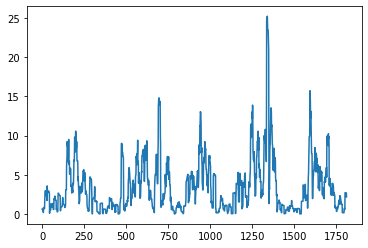

In [11]:
plt.plot(y_total)

In [12]:
class AE(nn.Module):
    def __init__(self, in_shape, hid_dim):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_shape, 600),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(600, 400),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(400, hid_dim),)
        
        self.decoder = nn.Sequential(             
            nn.Linear(hid_dim, 400),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(400, 600),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(600, in_shape),
            nn.Sigmoid(),)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [47]:
class CNN(nn.Module):
    def __init__(self, in_shape, hid_dim):
        super(CNN, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 2, 3, stride=2),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Conv1d(2, 4, 3, stride=2),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Conv1d(4, 8, 3, stride=2),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Conv1d(8, 16, 126, stride=1),
            nn.ReLU(True),
            nn.Dropout(0.2),
            )
        self.LL = nn.Linear(16,hid_dim)
        
#         self.decoder = nn.Sequential(             
#             nn.Linear(hid_dim, 400),
#             nn.ReLU(True),
#             nn.Dropout(0.3),
#             nn.Linear(400, 600),
#             nn.ReLU(True),
#             nn.Dropout(0.2),
#             nn.Linear(600, in_shape),
#             nn.Sigmoid(),)
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.view((-1,16))
        x = self.LL(x)
#         x = self.decoder(x)
        return x

In [61]:
cnn_test = CNN(1019,20)

In [57]:
testing = X_train.reshape((-1,1,1019))

In [58]:
testing.shape

(1448, 1, 1019)

In [59]:
testingres = cnn_test(torch.FloatTensor(testing))

In [60]:
testingres.shape

torch.Size([1448, 20])

In [13]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train_data = train_data.to(device)

In [15]:
class SimpleDataset(Dataset):
    def __init__(self, data):
        self.samples = data

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [16]:
BATCH_SIZE = 64
dataset_train = SimpleDataset(X_train)
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )


In [20]:
dataset_test = SimpleDataset(X_test)
dataloader_test = DataLoader(dataset_test,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [17]:
num_epochs = 20
losses = []
for epoch in range(num_epochs):
    running_loss = 0
    for data in dataloader_train:
        data = data.float().to(device)
        
        output = model(data)
        loss = distance(output, data)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss/len(dataloader_train)
    losses.append(train_loss)
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, train_loss))

epoch [1/20], loss:0.0693
epoch [2/20], loss:0.0469
epoch [3/20], loss:0.0324
epoch [4/20], loss:0.0241
epoch [5/20], loss:0.0209
epoch [6/20], loss:0.0210
epoch [7/20], loss:0.0208
epoch [8/20], loss:0.0186
epoch [9/20], loss:0.0170
epoch [10/20], loss:0.0171
epoch [11/20], loss:0.0163
epoch [12/20], loss:0.0177
epoch [13/20], loss:0.0183
epoch [14/20], loss:0.0165
epoch [15/20], loss:0.0164
epoch [16/20], loss:0.0149
epoch [17/20], loss:0.0158
epoch [18/20], loss:0.0165
epoch [19/20], loss:0.0150
epoch [20/20], loss:0.0146


In [21]:
compressed_X_train = np.zeros((BATCH_SIZE, hid_dim))
compressed_X_test = np.zeros((BATCH_SIZE, hid_dim))
model.eval()

c = 0
for data in dataloader_train:
    data = data.float().to(device)

    output = model.encoder((data))
    if c ==0:
        compressed_X_train = output.data.cpu().numpy()
    else:
        compressed_X_train = np.concatenate((compressed_X_train, output.data.cpu().numpy()), axis=0)
    c += 1
    
c = 0    
for data in dataloader_test:
        data = data.float().to(device)
        
        output = model.encoder((data))
        if c ==0:
            compressed_X_test = output.data.cpu().numpy()
        else:
            compressed_X_test = np.concatenate((compressed_X_test, output.data.cpu().numpy()), axis=0)
        c += 1

In [24]:
compressed_X_test.shape

(363, 20)

In [104]:
def create_sequence(input_data, train_window,pred_window):  #  Create sequences of observations for training
    seq = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    for i in range(L-train_window-pred_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window+pred_window-1,feature_size-1] # get y_t+14
        seq.append((train_seq ,train_label))
    return seq

In [106]:
y_train = np.reshape(y_train,(-1,1))  #  Matching dimension for concatenating X and y
y_test = np.reshape(y_test,(-1,1)) 
train_data_array = np.concatenate((X_train,y_train),axis=1)
train_data = torch.FloatTensor(train_data_array)
y_train = torch.FloatTensor(y_train)

In [107]:
train_data.shape

torch.Size([1450, 11])

In [108]:
device = torch.device("cuda:0")
train_data = train_data.to(device)
y_train = y_train.to(device)

In [109]:
train_window = 90
pred_window = 28
train_seq = create_sequence(train_data,train_window,pred_window)

In [110]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, num_layers=1, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(num_layers,1,self.hidden_layer_size),
                            torch.zeros(num_layers,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [111]:
model = LSTM(input_size=X_size+1, hidden_layer_size=100, num_layers=1, output_size=1).to(device) # 2 features from X_obs and 1 from y_obs
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [112]:
print(model)

LSTM(
  (lstm): LSTM(11, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [113]:
epochs = 100
#  Training the model
t0 = perf_counter()

for i in range(epochs):
    for seq, labels in train_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device),
                        torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device))

        pred = model(seq)
        labels = torch.reshape(labels,(-1,))  #  Match size to avoid warning
        single_loss = loss_function(pred, labels)
        single_loss.backward()
        optimizer.step()
    
   
                
    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
#     print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
t1 = perf_counter()
train_time = t1 - t0
print(f'Total training time: {train_time}')

epoch:   1 loss: 0.15086448
epoch:  11 loss: 0.00737573
epoch:  21 loss: 0.02535218
epoch:  31 loss: 0.00093528
epoch:  41 loss: 0.02829931
epoch:  51 loss: 0.01092113
epoch:  61 loss: 0.00117844
epoch:  71 loss: 0.00500207
epoch:  81 loss: 0.00014144
epoch:  91 loss: 0.03183883
epoch:  99 loss: 0.0185706634
Total training time: 388.83195550000164


In [114]:
# Predicting t+1
test_data = np.concatenate((X_test,y_test),axis=1)

train_test_total = np.concatenate((train_data_array,test_data))

model.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in range(train_test_total.shape[0]-train_window):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        #print(seq)
        with torch.no_grad():
            model.hidden = (torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device),
                            torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device))
            #print(model(seq))
            pred = model(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
res = np.array(res)

In [ ]:
# Predicting t+tau
test_data = np.concatenate((X_test,y_test),axis=1) 
train_test_total = np.concatenate((train_data_array,test_data))

model.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in range(train_test_total.shape[0]-train_window):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window])
        #print(seq)
        with torch.no_grad():
            model.hidden = (torch.zeros(model.num_layers, 1, model.hidden_layer_size),
                            torch.zeros(model.num_layers, 1, model.hidden_layer_size))
            #print(model(seq))
            pred = model(seq)
            #print(len(test_inputs))
            res.append(pred)

            

array([0.0, 0.0, 0.0, ..., tensor([0.3381], device='cuda:0'),
       tensor([0.3555], device='cuda:0'),
       tensor([0.4765], device='cuda:0')], dtype=object)

r-sq on train: 0.6120868988630799
r-sq on test: 0.591112255964871
cosine_similarity on train: [[0.78573143]]
cosine_similarity on test: [[0.77760496]]


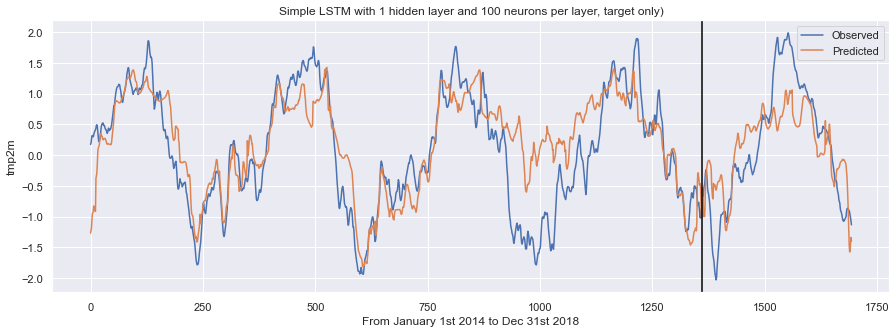

In [115]:
y_train = y_train.cpu()
y_train_true = y_samp[train_window+pred_window:-test_size]
y_train_pred = res[train_window:-test_size-pred_window]
y_test_true = y_samp[-test_size:]
y_test_pred = res[-test_size-pred_window:-pred_window]
print('r-sq on train:', r2_score(y_train_true, y_train_pred))
print('r-sq on test:', r2_score(y_test_true,  y_test_pred))
plt.figure(figsize=(15,5))
plt.plot(y_samp[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Simple LSTM with 1 hidden layer and 100 neurons per layer, target only)')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black')
print('cosine_similarity on train:', cosine_similarity(y_train_true.reshape((1,-1)), y_train_pred.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_test_true.reshape((1,-1)),  y_test_pred.reshape((1,-1))))

In [29]:
y_train_true.reshape((-1,1)).shape

(1392, 1)

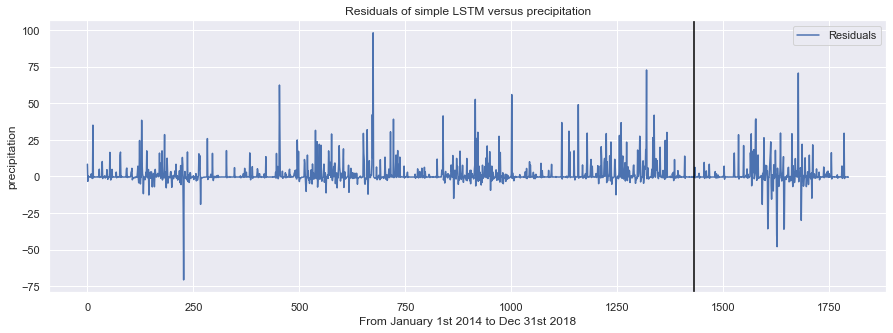

In [28]:
plt.figure(figsize=(15,5))
plt.plot(y_samp[train_window:] - res[train_window:] ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel('precipitation')
plt.title('Residuals of simple LSTM versus precipitation')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black')

In [54]:
np.sum((np.array(res[train_size:]) - y_test[:,0]) ** 2)/y_test.shape[0]  # MSE


tensor([0.6813], device='cuda:0')

In [429]:
tmp2m = pd.DataFrame(pd.read_hdf('SSF/tmp2m.2018.h5')).reset_index()


In [432]:
test = tmp2m[(tmp2m['lat']==25.25) & (tmp2m['lon']==279.25)]
test

,lat,lon,start_date,0
8108021,25.25,279.25,2018-01-01,20.244444
8108022,25.25,279.25,2018-01-02,17.381365
8108023,25.25,279.25,2018-01-03,15.314527
8108024,25.25,279.25,2018-01-04,10.294666
8108025,25.25,279.25,2018-01-05,11.791142
...,...,...,...,...
8108381,25.25,279.25,2018-12-27,24.758492
8108382,25.25,279.25,2018-12-28,25.610886
8108383,25.25,279.25,2018-12-29,24.864708
8108384,25.25,279.25,2018-12-30,23.908970


In [15]:
import pyflux as pf
test = pd.DataFrame(y_samp).astype('double')
model_VAR = pf.VAR(data=test,lags=7,integ=1)